<a href="https://colab.research.google.com/github/Kshitij879/PnemoniaDetection/blob/main/Copy_of_Pneumonia_Detection_model_VGG16_model(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h2> <b>What is Pneumonia?</b></h2>

<p> <blockquote> Pneumonia is an inflammatory condition of the lung affecting primarily the small air sacs known as alveoli.Symptoms typically include some combination of productive or dry cough, chest pain, fever and difficulty breathing. The severity of the condition is variable. Pneumonia is usually caused by infection with viruses or bacteria and less commonly by other microorganisms, certain medications or conditions such as autoimmune diseases.Risk factors include cystic fibrosis, chronic obstructive pulmonary disease (COPD), asthma, diabetes, heart failure, a history of smoking, a poor ability to cough such as following a stroke and a weak immune system. Diagnosis is often based on symptoms and physical examination. Chest X-ray, blood tests, and culture of the sputum may help confirm the diagnosis.The disease may be classified by where it was acquired, such as community- or hospital-acquired or healthcare-associated pneumonia.</blockquote> </p>



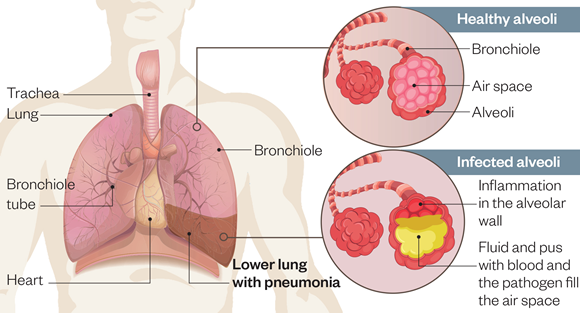

<h2> <b> Bacterial Pneumonia </b></h2>

<p> Pneumonia caused by a bacterium is called bacterial pneumonia. There are many types of bacteria that may cause bacterial pneumonia, but the most common type Streptococcus pneumoniae.

Common symptoms of bacterial pneumonia include:

* Chest pain  
* Shortness of breath
* Sputum that is yellow or green mucus while coughing
* Chills
* Fever
* Fatigue

Bacterial pneumonia requires antibiotics for treatment; ideally, the antibiotic will target the specific type of bacteria. Steroids may also be used to improve breathing.
 </p>
<h2> <b> Viral Pneumonia </b></h2>
<p>Approximately 30% of pneumonia cases are viral. This type of pneumonia typically occurs as a secondary infection from other viruses such as influenza, coronavirus, parainfluenza, adenovirus, and respiratory syncytial virus (RSV).

These types of viruses spread through air droplets. For example, a sneeze or a cough may cause sputum an air droplet to spread through the air, or the virus could land on a doorknob or a surface that is touched, then brought to the nose or mouth.

Symptoms of viral pneumonia are similar, although there are differences:

* A dry cough (note that there is rarely sputum produced with viral pneumonia)
*Fever
*Chills
*Chest pain
*Shortness of breath

While bacterial pneumonia is treated with antibiotics, this treatment will not help bacterial pneumonia. Viruses are not receptive to antibiotics. Occasionally, antiviral medications may be prescribed.
</p>


# Import Libraries

In [43]:
import numpy as np 
import pandas as pd 

import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, AvgPool2D, MaxPool2D , Flatten , Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2
import os

print(tf.__version__)

2.3.0


# Load Data :

In [44]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150
def get_input_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        diag= ""
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                # Reshaping images to preferred size
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) 
                if "bacteria" in img:
                    diag = [1,0,0] 
                elif "virus" in img:
                    diag = [0,1,0] 
                else:
                    diag = [0,0,1]              
                data.append([resized_arr, class_num, diag])
            except Exception as e:
                print(img, e)
    return np.array(data)

In [45]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [46]:
train = get_input_data('/content/gdrive/My Drive/chest_xray/train')
test = get_input_data('/content/gdrive/My Drive/chest_xray/test')
val = get_input_data('/content/gdrive/My Drive/chest_xray/val')

# Data Visualization and processing

Text(0.5, 1.0, 'Viral Pneumonia')

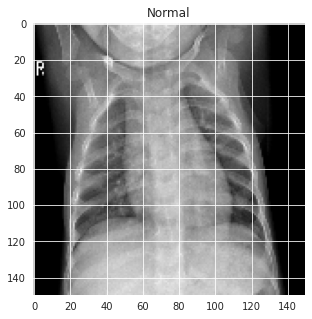

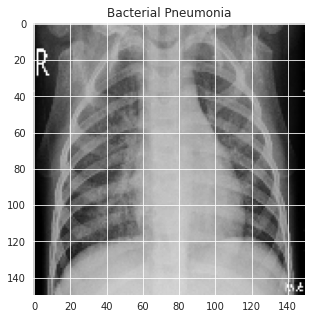

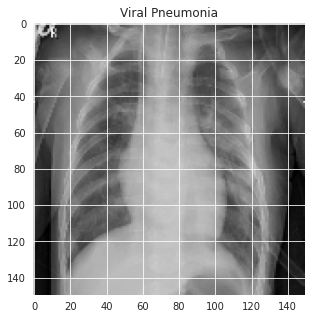

In [47]:
plt.figure(figsize = (5,5))
plt.imshow(train[-1][0], cmap='gray', )
plt.title(label='Normal')

plt.figure(figsize = (5,5))
plt.imshow(train[0][0], cmap='gray')
plt.title(label='Bacterial Pneumonia')

plt.figure(figsize = (5,5))
plt.imshow(train[1][0], cmap='gray')
plt.title(label='Viral Pneumonia')



<h2> Printing initial data :</h2>

In [48]:
def display_set(one_set, order = ["pneumonia bacteria", "pneumonia virus", "normal"]):
    l = []
    for i in one_set:
        if i[2] == [1,0,0]:
            diag = "pneumonia bacteria"
        elif i[2] == [0,1,0]:
            diag = "pneumonia virus"
        else:
            diag = "normal"
        l.append(diag)
    sns.set_style('darkgrid')
    sns.countplot(l, order = order)  

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


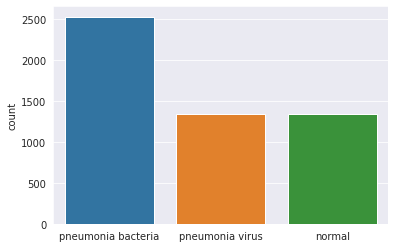

In [49]:
display_set(train)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


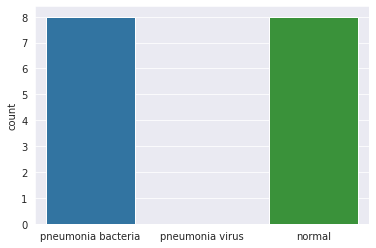

In [50]:
display_set(val)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


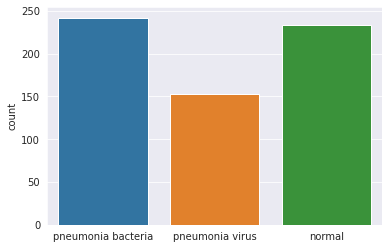

In [51]:
display_set(test)

<h4> The training data seems unbalanced. The validation data has very less of viral pneumonia data.</h4>

<h3> Redistributing x-rays to create balanced train and validation dataset :</h3>

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'All data')

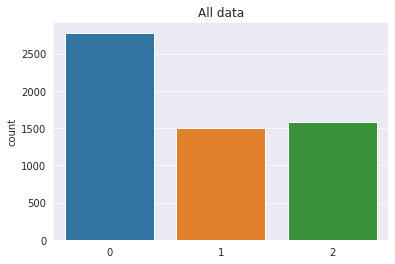

In [52]:
x_data = []
y_data = []

for feature, label, diag in train:
    x_data.append(feature)
    y_data.append(diag)

for feature, label, diag in test:
    x_data.append(feature)
    y_data.append(diag)
    
for feature, label, diag in val:
    x_data.append(feature)
    y_data.append(diag)

y_class_num = [np.where(np.asarray(r)==1)[0][0] for r in y_data]
sns.countplot(y_class_num).set_title('All data')

<h3> Resizing test dataset:

number of sampels per category 1498


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Final data')

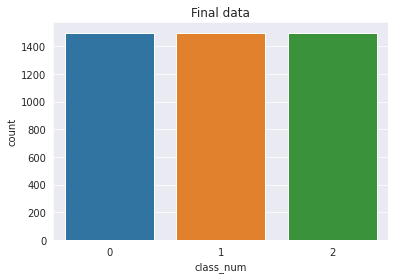

In [53]:
samples = pd.DataFrame(y_class_num, columns = ['class_num'])
samples['diag'] = y_data
samples['img'] = x_data

smallest_diag_count = samples['class_num'].value_counts().min()
print("number of sampels per category", smallest_diag_count)

class0 = samples[samples['class_num'] == 0].sample(smallest_diag_count)
class1 = samples[samples['class_num'] == 1].sample(smallest_diag_count)
class2 = samples[samples['class_num'] == 2].sample(smallest_diag_count)

samples_under = pd.concat([class0, class1, class2], axis=0)

x = samples_under['img'].tolist()
y = samples_under['diag'].tolist()
sns.countplot(samples_under['class_num']).set_title('Final data')

Splitting data into 70% train, 15% validation and 15% test

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Training data')

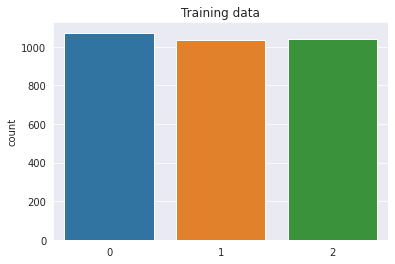

In [54]:
# shuffling the samples to have matching ditributions regarding the differents sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, shuffle=True)
sns.countplot([np.where(np.asarray(r)==1)[0][0] for r in y_train]).set_title('Training data')

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Validation data')

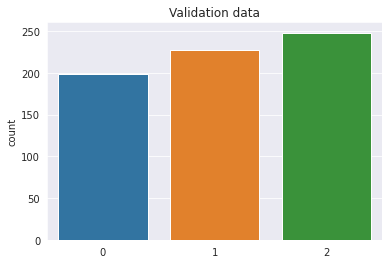

In [55]:
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5, shuffle=False)
sns.countplot([np.where(np.asarray(r)==1)[0][0] for r in y_val]).set_title('Validation data')

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Test data')

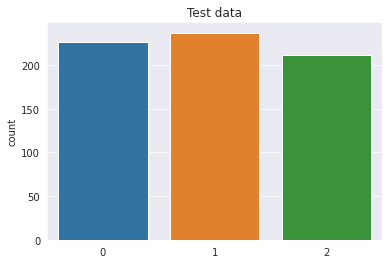

In [56]:
sns.countplot([np.where(np.asarray(r)==1)[0][0] for r in y_test]).set_title('Test data')

We perform a grayscale normalization to reduce the effect of illumination's differences.Moreover the CNN converges faster on [0..1] data than on [0..255].

In [57]:
# Normalize the data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

In [58]:
# resize data for deep learning 
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

DATA AUGMENTATION

In [59]:
# With data augmentation to prevent overfitting and handling the imbalance in dataset

train_datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = False,  # randomly flip images
        vertical_flip=False)  # randomly flip images
train_datagen.fit(x_train)

valid_datagen = ImageDataGenerator()

test_datagen = ImageDataGenerator()


train_generator = train_datagen.flow(
    x_train,
    y_train,
    batch_size = 32)

validation_generator = valid_datagen.flow(
    x_val,
    y_val)

test_generator = test_datagen.flow(
    x_test,
    y_test)


TRAIN MODEL

In [60]:

model = Sequential()
model.add(Conv2D(input_shape=(150,150,1),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Flatten())
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=4096,activation="relu"))



model.add(Dense(units=3, activation="softmax"))
from keras.optimizers import Adam
opt = Adam(lr=0.0001)
model.compile(optimizer = opt , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
model.summary()




Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_26 (Conv2D)           (None, 150, 150, 64)      640       
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 150, 150, 64)      36928     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 75, 75, 64)        0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 75, 75, 128)       73856     
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 75, 75, 128)       147584    
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 37, 37, 128)       0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 37, 37, 256)      

In [61]:

class_weight = {0: 3, 1: 3, 2: 1}
loops = 20
history = []

for x in range(loops):
    history.append(model.fit(
            train_generator,
            steps_per_epoch=97,
            epochs=1,
            validation_data=test_generator,
            validation_steps=20,
            class_weight=class_weight))

97/97 [==============================] - 44s 451ms/step - loss: 1.3976 - accuracy: 0.7533 - val_loss: 0.5048 - val_accuracy: 0.7734


In [62]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0]*100)
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

22/22 [==============================] - 3s 123ms/step - loss: 0.5065 - accuracy: 0.7719
Loss of the model is -  50.64689517021179
22/22 [==============================] - 3s 123ms/step - loss: 0.5065 - accuracy: 0.7719
Accuracy of the model is -  77.18518376350403 %


In [63]:
print(history[0].history)


{'loss': [2.3826851844787598], 'accuracy': [0.32294708490371704], 'val_loss': [1.2048307657241821], 'val_accuracy': [0.3343749940395355]}


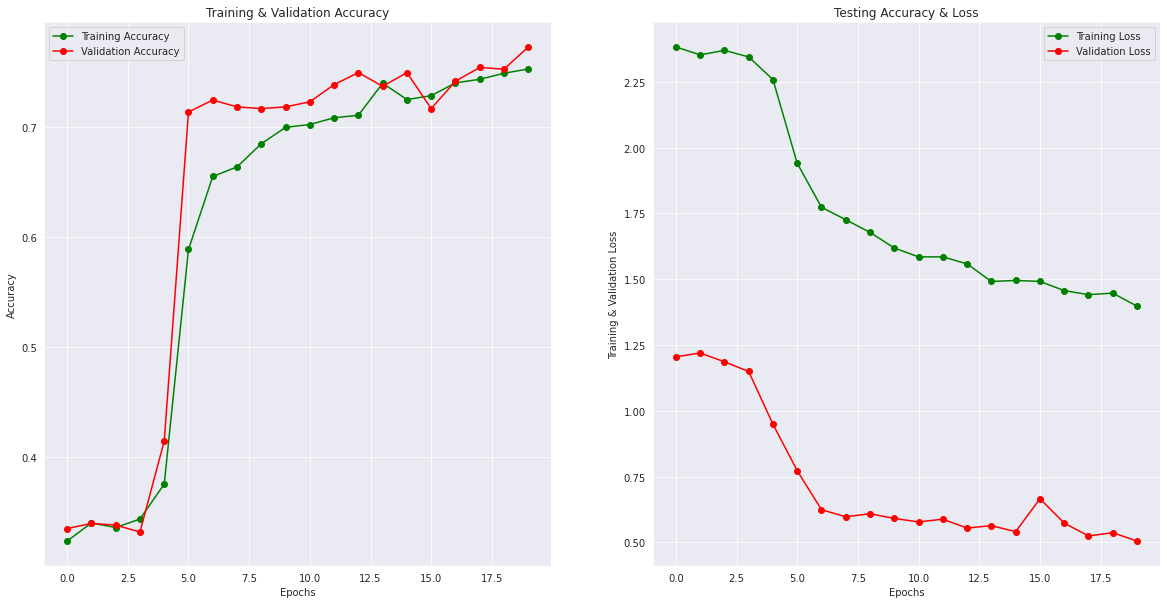

In [64]:
epochs = [i for i in range(20)]
fig , ax = plt.subplots(1,2)
train_acc = []
train_loss = []
val_acc = []
val_loss = []
for h in history:
    train_acc.append(h.history['accuracy'])
    train_loss.append(h.history['loss'])    
    val_acc.append(h.history['val_accuracy'])
    val_loss.append(h.history['val_loss'])
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

In [65]:
predictions = model.predict_classes(x_test)
y_test_num = [np.where(r==1)[0][0] for r in y_test]
names = ['Pneumonia Bacteria', 'Pneumonia Virus','Normal']


print(classification_report(y_test_num, predictions, target_names = names))

                    precision    recall  f1-score   support

Pneumonia Bacteria       0.67      0.84      0.74       226
   Pneumonia Virus       0.78      0.55      0.65       237
            Normal       0.90      0.95      0.92       212

          accuracy                           0.77       675
         macro avg       0.78      0.78      0.77       675
      weighted avg       0.78      0.77      0.77       675



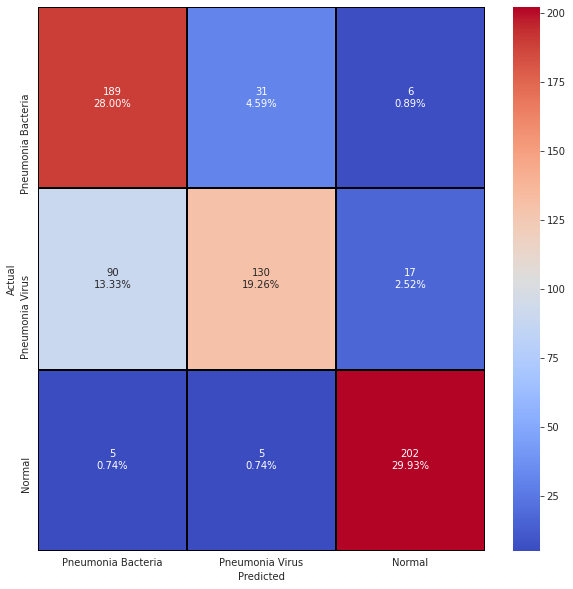

In [66]:
cm = confusion_matrix(y_test_num,predictions)
cm = pd.DataFrame(cm , index = names , columns = names)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'

group_counts = ["{0:0.0f}".format(value) for value in cm.to_numpy().flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm.to_numpy().flatten()/np.sum(cm.to_numpy())]
labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts,group_percentages)]
labels = np.asarray(labels).reshape(3,3)

plt.figure(figsize = (10,10))
sns.heatmap(cm,
            annot=labels,
            cmap= "coolwarm",
            linecolor = 'black',
            linewidth = 1,
            fmt='')